In [1]:
import numpy as np
import torch
import copy
import matplotlib.pyplot as plt


from ICML_comparisons import *
from ICML_MVRseq import *
from ICML_ILP import hmm_constrained_inference
from ICML_beam_search import *

In [2]:
import gc
# Clear all cached memory
torch.cuda.empty_cache()

# Force Python garbage collection
gc.collect()

# Clear cache again after garbage collection
torch.cuda.empty_cache()

# Experiments: Generate HMM

In [3]:
# Generate random HMM
print("=== Generating Random HMM ===")
num_states = 50
num_emissions = 10
hmm_params = generate_random_hmm(num_states, num_emissions, seed=42)
transition_matrix, emission_matrix, initial_vector = hmm_params

print(f"Generated HMM with {num_states} states and {num_emissions} emissions")

hidden_states = list(range(num_states))
emit_states = list(range(num_emissions))
hidden_size, emit_size = len(hidden_states), len(emit_states)


hmm_transition = {}
for i in range(hidden_size):
    for j in range(hidden_size):
        hmm_transition[hidden_states[i],hidden_states[j]] = transition_matrix[i,j].item()

hmm_emit = {}
for i in range(hidden_size):
    for j in range(emit_size):
        hmm_emit[hidden_states[i],emit_states[j]] = emission_matrix[i,j].item()
        
hmm_startprob = {}
for i in range(hidden_size):
    hmm_startprob[hidden_states[i]] = initial_vector[i]

hmm = copy.deepcopy(Munch(states = hidden_states, emits = emit_states, tprob = hmm_transition, eprob = hmm_emit, initprob = hmm_startprob))

=== Generating Random HMM ===
Generated HMM with 50 states and 10 emissions


In [38]:
# Define constraint: encourage consecutive sequence [0,1,2,...,N-1]
constraint_length = 10
print(f"\n=== Constraint: Consecutive Sequence [0,1,2,...,{constraint_length-1}] ===")
required_transitions = [(i, i+1) for i in range(constraint_length - 1)]
print(f"Required transitions: {required_transitions}")

#Create constraint object for MVR
seq_cst = create_seqconstraint(num_states,constraint_length)
cst_list = [seq_cst]

# Sample from the HMM
print("\n=== Sampling from HMM ===")
states, observations = sample_from_hmm(
    transition_matrix, emission_matrix, initial_vector,
    sequence_length=100,
    constraint_length=constraint_length,  # Inject consecutive sequence when 0 is encountered
    seed=123
)
print(f"Sequence length: {len(observations)}")
print(f"First 20 hidden states: {states[:20].tolist()}")
print(f"First 20 observations:  {observations[:20].tolist()}")

# Verify the contiguous sequence is present
max_consecutive_in_sample = find_longest_consecutive_sequence(
    [s.item() for s in states], 
    start_state=0
)
print(f"Verified: Sample contains contiguous sequence [0, 1, ..., {max_consecutive_in_sample-1}] (length {max_consecutive_in_sample}/{constraint_length})")
if max_consecutive_in_sample >= constraint_length:
    print(f"Full constraint sequence present in sample")
else:
    print(f"WARNING: Sample only has partial sequence")

# Find the ground truth endpoint
endpoint_idx = find_constraint_endpoint(states, constraint_length)
print(f"Ground truth constraint endpoint: index {endpoint_idx} (state {states[endpoint_idx].item()})")


=== Constraint: Consecutive Sequence [0,1,2,...,9] ===
Required transitions: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)]

=== Sampling from HMM ===
Sequence length: 100
First 20 hidden states: [37, 49, 2, 47, 33, 9, 1, 38, 24, 18, 10, 28, 0, 1, 2, 3, 4, 5, 6, 7]
First 20 observations:  [4, 0, 6, 4, 0, 3, 5, 3, 2, 6, 6, 7, 4, 6, 6, 0, 3, 4, 9, 5]
Verified: Sample contains contiguous sequence [0, 1, ..., 9] (length 10/10)
Full constraint sequence present in sample
Ground truth constraint endpoint: index 21 (state 9)


In [39]:
seq_cst = create_seqconstraint(num_states,constraint_length)
cst_list = [seq_cst]
cst_parameters = create_seq_cst_params(num_states, constraint_length, device='cpu')
input_list = Viterbi_preprocess(hmm, cst_list, observations.tolist(), dtype = torch.float32,  device = 'cuda:0', debug = False, hmm_params = [transition_matrix,initial_vector], cst_params = cst_parameters)
# input_list2 = Viterbi_preprocess(hmm, cst_list, observations.tolist(), dtype = torch.float32,  device = 'cuda:0', debug = False, hmm_params = [transition_matrix,initial_vector])
# for i in range(1,4):
#     print(torch.norm(input_list[2][i][0] - input_list2[2][i][0]))

# Testing Algorithms

In [40]:
#MV
start = time.time()
opt_state_list, opt_augstateix_list = Viterbi_torch_list(input_list, observations.tolist(), dtype = torch.float32,  device = 'cuda:0', debug = False, num_corr = 0)
time_elapsed = time.time() - start

print(f"Time: {time_elapsed:.4f}s")

print("Top decoded path:")
print(f"  Path: {opt_state_list[:20]}... (first 20 states)")
print(f"  Score: {hmm_log_probability(opt_state_list, observations.tolist(), initial_vector, transition_matrix, emission_matrix):.4f}")

# Check which required transitions appear in top path
print(f"\n=== Sequence Analysis ===")
top_path = torch.tensor(opt_state_list)
max_consecutive_length = find_longest_consecutive_sequence(top_path, start_state=0)
print(f"Longest consecutive sequence found: [0, 1, ..., {max_consecutive_length-1}] (length {max_consecutive_length})")
print(f"Target constraint length: {constraint_length}")
if max_consecutive_length >= constraint_length:
    print(f"MVR successfully recovered the full constraint sequence!")
else:
    print(f"MVR found partial sequence ({max_consecutive_length}/{constraint_length})")

infer_endpoint_idx = find_constraint_endpoint(top_path, constraint_length)
endpoint_idx = find_constraint_endpoint(states, constraint_length)

print(f"Inferred constraint endpoint: index {infer_endpoint_idx} (state {top_path[infer_endpoint_idx].item()})")
print(f"Ground truth constraint endpoint: index {endpoint_idx} (state {states[endpoint_idx].item()})")

Time: 0.0572s
Top decoded path:
  Path: [30, 49, 18, 12, 42, 14, 1, 48, 17, 18, 22, 35, 30, 49, 18, 3, 25, 22, 35, 1]... (first 20 states)
  Score: -409.0121

=== Sequence Analysis ===
Longest consecutive sequence found: [0, 1, ..., 9] (length 10)
Target constraint length: 10
MVR successfully recovered the full constraint sequence!
Inferred constraint endpoint: index 60 (state 9)
Ground truth constraint endpoint: index 21 (state 9)


In [41]:
# Test both version of beam search
print("\n=== Testing Implementation Match ===")

# Create original bonus function
bonus_fn_original = create_sequence_bonus_incentive(
    constraint_length=constraint_length,
    bonus_per_transition=3.0
)

# Create vectorized bonus function
bonus_matrix, bonus_fn_vectorized = create_sequence_bonus_incentive_vectorized(
    constraint_length=constraint_length,
    bonus_per_transition=3.0,
    device=device,
    num_states=transition_matrix.shape[0]
)
bonus_fn_vectorized.bonus_matrix = bonus_matrix

# Run original implementation
print("\nRunning original implementation...")
start = time.time()
paths_original, scores_original = hmm_beam_search(
    transition_matrix=transition_matrix,
    emission_matrix=emission_matrix,
    initial_vector=initial_vector,
    observations=observations,
    beam_width=5,
    bonus_fn=bonus_fn_original
)
time_original = time.time() - start
print(f"Time: {time_original:.4f}s")

# Run vectorized implementation
print("\nRunning vectorized implementation...")
start = time.time()
paths_vectorized, scores_vectorized = hmm_beam_search_vectorized(
    transition_matrix=transition_matrix,
    emission_matrix=emission_matrix,
    initial_vector=initial_vector,
    observations=observations,
    beam_width=5,
    device = device,
    bonus_fn=bonus_fn_vectorized
)
time_vectorized = time.time() - start
print(f"Time: {time_vectorized:.4f}s")
print(f"Speedup: {time_original/time_vectorized:.2f}x")

# Compare results
print("\n=== Comparison ===")
paths_match = paths_vectorized[0] == paths_original[0]
scores_close = torch.allclose(scores_vectorized[0], scores_original[0], atol=1e-4)
score_diff = abs(scores_vectorized[0].item() - scores_original[0].item())

print(f"Top paths match: {paths_match}")
print(f"Top scores close (atol=1e-4): {scores_close}")
print(f"Score difference: {score_diff:.6f}")

if paths_match and scores_close:
    print("\n✓ PASS: Implementations match!")
else:
    print("\n✗ FAIL: Implementations differ!")
    print(f"Original path (first 20): {paths_original[0][:20]}")
    print(f"Vectorized path (first 20): {paths_vectorized[0][:20]}")
    print(f"Original score: {scores_original[0].item():.6f}")
    print(f"Vectorized score: {scores_vectorized[0].item():.6f}")


=== Testing Implementation Match ===

Running original implementation...
Time: 0.4308s

Running vectorized implementation...
Time: 0.0443s
Speedup: 9.73x

=== Comparison ===
Top paths match: True
Top scores close (atol=1e-4): True
Score difference: 0.000031

✓ PASS: Implementations match!


In [15]:
# Run beam search with bonus function
print("\n=== Running Beam Search with Bonus Function ===")
bonus_fn = create_sequence_bonus_incentive(
    constraint_length=constraint_length,
    bonus_per_transition=3.0
)

# start = time.time()
# paths, scores = hmm_beam_search(
#     transition_matrix=transition_matrix,
#     emission_matrix=emission_matrix,
#     initial_vector=initial_vector,
#     observations=observations,
#     beam_width=5,
#     bonus_fn=bonus_fn
# )
# time_elapsed = time.time() - start

# print(f"Time: {time_elapsed:.4f}s")
# print("Top decoded path:")
# print(f"  Path: {paths[0][:20]}... (first 20 states)")
# print(f"  Score: {scores[0]:.4f}")

# # Check which required transitions appear in top path
# print(f"\n=== Sequence Analysis ===")
# top_path = paths[0]
# max_consecutive_length = find_longest_consecutive_sequence(top_path, start_state=0)
# print(f"Longest consecutive sequence found: [0, 1, ..., {max_consecutive_length-1}] (length {max_consecutive_length})")
# print(f"Target constraint length: {constraint_length}")
# if max_consecutive_length >= constraint_length:
#     print(f"✓ Beam search successfully recovered the full constraint sequence!")
# else:
#     print(f"✗ Beam search found partial sequence ({max_consecutive_length}/{constraint_length})")

# print(f"\nTrue hidden states (first 20): {states[:20].tolist()}")


# Run beam search with vectorized bonus function
print("\n=== Running Beam Search with Vectorized Bonus Function ===")

# # Create vectorized bonus function with correct num_states
# device = transition_matrix.device
# N = transition_matrix.shape[0]  # Get number of states

bonus_matrix, bonus_fn = create_sequence_bonus_incentive_vectorized(
    constraint_length=constraint_length,
    bonus_per_transition=3.0,
    device=device,
    num_states=transition_matrix.shape[0]  # Pass the number of states
)

# Attach the bonus matrix to the function for vectorized access
bonus_fn.bonus_matrix = bonus_matrix

start = time.time()
paths, scores = hmm_beam_search_vectorized(
    transition_matrix=transition_matrix,
    emission_matrix=emission_matrix,
    initial_vector=initial_vector,
    observations=observations,
    beam_width=5,
    device = device,
    bonus_fn=bonus_fn
)
time_elapsed = time.time() - start
print(f"Time: {time_elapsed:.4f}s")
print("Top decoded path:")
print(f"  Path: {paths[0][:20]}... (first 20 states)")
print(f"  Score: {scores[0]:.4f}")


# Check which required transitions appear in top path
print(f"\n=== Sequence Analysis ===")
top_path = paths[0]
max_consecutive_length = find_longest_consecutive_sequence(top_path, start_state=0)
print(f"Longest consecutive sequence found: [0, 1, ..., {max_consecutive_length-1}] (length {max_consecutive_length})")
print(f"Target constraint length: {constraint_length}")
if max_consecutive_length >= constraint_length:
    print(f"✓ Beam search successfully recovered the full constraint sequence!")
else:
    print(f"✗ Beam search found partial sequence ({max_consecutive_length}/{constraint_length})")

print(f"\nTrue hidden states (first 20): {states[:20].tolist()}")



=== Running Beam Search with Bonus Function ===

=== Running Beam Search with Vectorized Bonus Function ===
Time: 0.0965s
Top decoded path:
  Path: [800, 804, 507, 461, 766, 849, 384, 118, 251, 522, 592, 619, 718, 613, 412, 295, 302, 780, 76, 807]... (first 20 states)
  Score: -561.1072

=== Sequence Analysis ===
Longest consecutive sequence found: [0, 1, ..., -1] (length 0)
Target constraint length: 10
✗ Beam search found partial sequence (0/10)

True hidden states (first 20): [609, 557, 343, 315, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 168, 789, 455, 773, 220, 216]


In [8]:
# Example usage - can be run directly in Jupyter
# Simple example: 5 states, 2 observation symbols, sequence length 15
K = 10  # number of states
M = 5  # number of observation symbols
T = 10  # sequence length
N = 4  # require subsequence [0, 1, 2, 3] to occur

# Create random HMM parameters (in log space)
torch.manual_seed(31)
transition = torch.randn(K, K)
emission = torch.randn(K, M)
initial = torch.randn(K)

# Random observations
observations = torch.randint(0, M, (T,))

print("Observations:", observations.tolist())
print(f"Required subsequence: [0, 1, ..., {N-1}]")

# Run constrained inference
states, solve_time = hmm_constrained_inference(
    observations, transition, emission, initial, N
)

print("Inferred states:", states.tolist())
print(f"ILP solve time: {solve_time:.4f} seconds")

# Verify constraint is satisfied
def check_subsequence(states, N):
    """Check if subsequence [0, 1, ..., N-1] occurs in states."""
    for t in range(len(states) - N + 1):
        if all(states[t + i] == i for i in range(N)):
            return True, t
    return False, None

found, start_pos = check_subsequence(states, N)
if found:
    print(f"✓ Subsequence [0, 1, ..., {N-1}] found starting at position {start_pos}")
else:
    print(f"✗ Subsequence [0, 1, ..., {N-1}] NOT found")

Observations: [4, 1, 0, 3, 2, 1, 3, 2, 2, 1]
Required subsequence: [0, 1, ..., 3]
Inferred states: [7, 6, 8, 4, 0, 5, 0, 1, 2, 3]
ILP solve time: 3.2232 seconds
✓ Subsequence [0, 1, ..., 3] found starting at position 6


# Beam vs MVR

## Runtime vs Space

In [3]:
sizes = [100*i + 50 for i in range(10)]
batch = 25
constraint_length = 10
device = torch.device("cuda:0")

required_transitions = [(i, i+1) for i in range(constraint_length - 1)]


In [4]:
# Generate random HMM
size_exp_beam = []
size_exp_beam_vec = []
size_exp_mv = []

for size in sizes:
    
    #Generate HMM
    num_states = size
    num_emissions = 10
    hmm_params = generate_random_hmm(num_states, num_emissions, seed=42)
    transition_matrix, emission_matrix, initial_vector = hmm_params


    hidden_states = list(range(num_states))
    emit_states = list(range(num_emissions))
    hidden_size, emit_size = len(hidden_states), len(emit_states)


    hmm_transition = {}
    for i in range(hidden_size):
        for j in range(hidden_size):
            hmm_transition[hidden_states[i],hidden_states[j]] = transition_matrix[i,j].item()

    hmm_emit = {}
    for i in range(hidden_size):
        for j in range(emit_size):
            hmm_emit[hidden_states[i],emit_states[j]] = emission_matrix[i,j].item()

    hmm_startprob = {}
    for i in range(hidden_size):
        hmm_startprob[hidden_states[i]] = initial_vector[i]

    hmm = copy.deepcopy(Munch(states = hidden_states, emits = emit_states, tprob = hmm_transition, eprob = hmm_emit, initprob = hmm_startprob))
    
    #Intialize bonus function for each size
    bonus_fn = create_sequence_bonus_incentive(
        constraint_length=constraint_length,
        bonus_per_transition=3.0
    )
    
    #Initialize bonus matrix 
    bonus_matrix, bonus_fn_vec = create_sequence_bonus_incentive_vectorized(
        constraint_length=constraint_length,
        bonus_per_transition=3.0,
        device=device,
        num_states=transition_matrix.shape[0]
    )
    # Attach the bonus matrix to the function for vectorized access
    bonus_fn_vec.bonus_matrix = bonus_matrix
    
    #Create constraint object for MVR
    seq_cst = create_seqconstraint(num_states,constraint_length)
    cst_list = [seq_cst]
    cst_parameters = create_seq_cst_params(num_states, constraint_length, device='cpu')

    #Initialize list of times
    times_beam = []
    times_mv = []
    times_beam_vec = []
    #Runtime experiments
    for b in range(batch):
        if b % 10 == 0:
            print(f'On size {size} and run {b}')
 
        states, observations = sample_from_hmm(
            transition_matrix, emission_matrix, initial_vector,
            sequence_length=100,
            constraint_length=constraint_length  # Inject consecutive sequence when 0 is encountered
        )

        #Beam Search
        start = time.time()
        paths, scores = hmm_beam_search(
            transition_matrix=transition_matrix,
            emission_matrix=emission_matrix,
            initial_vector=initial_vector,
            observations=observations,
            beam_width=5,
            bonus_fn=bonus_fn
        )
        time_elapsed = time.time() - start
        times_beam.append(time_elapsed)
        
        #MV
        input_list = Viterbi_preprocess(hmm, cst_list, observations.tolist(), dtype = torch.float32,  device = 'cuda:0', debug = False, hmm_params = [transition_matrix,initial_vector], cst_params = cst_parameters)
        start = time.time()
        opt_state_list, opt_augstateix_list = Viterbi_torch_list(input_list, observations.tolist(), dtype = torch.float32,  device = 'cuda:0', debug = False, num_corr = 0)
        time_elapsed = time.time() - start
        times_mv.append(time_elapsed)
        
        #Vectorized Beam Search
        start = time.time()
        paths, scores = hmm_beam_search_vectorized(
            transition_matrix=transition_matrix,
            emission_matrix=emission_matrix,
            initial_vector=initial_vector,
            observations=observations,
            beam_width=5,
            device = device,
            bonus_fn=bonus_fn_vec
        )
        time_elapsed = time.time() - start
        times_beam_vec.append(time_elapsed)
        
    
    size_exp_beam.append(times_beam)
    size_exp_mv.append(times_mv)
    size_exp_beam_vec.append(times_beam_vec)


On size 50 and run 0
On size 50 and run 10
On size 50 and run 20
On size 150 and run 0
On size 150 and run 10
On size 150 and run 20
On size 250 and run 0
On size 250 and run 10
On size 250 and run 20
On size 350 and run 0
On size 350 and run 10
On size 350 and run 20
On size 450 and run 0
On size 450 and run 10
On size 450 and run 20
On size 550 and run 0
On size 550 and run 10
On size 550 and run 20
On size 650 and run 0
On size 650 and run 10
On size 650 and run 20
On size 750 and run 0
On size 750 and run 10
On size 750 and run 20
On size 850 and run 0
On size 850 and run 10
On size 850 and run 20
On size 950 and run 0
On size 950 and run 10
On size 950 and run 20


In [16]:
import pickle

# with open('size_exp_beam.pkl', 'wb') as f:
#     pickle.dump([size_exp_mv, size_exp_beam, size_exp_beam_vec], f)


# # Loading from pickle file
# with open('size_exp_beam.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)


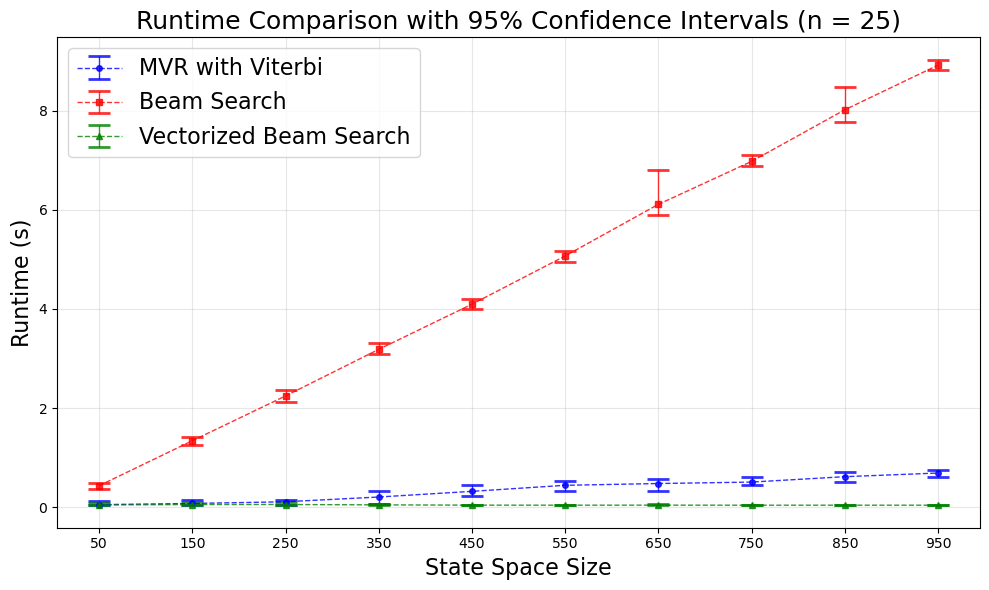

In [38]:
# Compute statistics for Algorithm 1
means_1 = [np.mean(runs) for runs in size_exp_mv]
lower_1 = [np.percentile(runs, 2.5) for runs in size_exp_mv]
upper_1 = [np.percentile(runs, 97.5) for runs in size_exp_mv]

# Compute statistics for Algorithm 2
means_2 = [np.mean(runs) for runs in size_exp_beam]
lower_2 = [np.percentile(runs, 2.5) for runs in size_exp_beam]
upper_2 = [np.percentile(runs, 97.5) for runs in size_exp_beam]

# Compute statistics for Algorithm 3
means_3 = [np.mean(runs) for runs in size_exp_beam_vec]
lower_3 = [np.percentile(runs, 2.5) for runs in size_exp_beam_vec]
upper_3 = [np.percentile(runs, 97.5) for runs in size_exp_beam_vec]

# Convert to error bar format (distance from mean)
yerr_lower_1 = np.array(means_1) - np.array(lower_1)
yerr_upper_1 = np.array(upper_1) - np.array(means_1)
yerr_lower_2 = np.array(means_2) - np.array(lower_2)
yerr_upper_2 = np.array(upper_2) - np.array(means_2)
yerr_lower_3 = np.array(means_3) - np.array(lower_3)
yerr_upper_3 = np.array(upper_3) - np.array(means_3)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Algorithm 1 with error bars
ax.errorbar(sizes, means_1, yerr=[yerr_lower_1, yerr_upper_1],
            fmt='o--', color='blue', label='MVR with Viterbi',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

# Plot Algorithm 2 with error bars
ax.errorbar(sizes, means_2, yerr=[yerr_lower_2, yerr_upper_2],
            fmt='s--', color='red', label='Beam Search',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

# Plot Algorithm 3 with error bars
ax.errorbar(sizes, means_3, yerr=[yerr_lower_3, yerr_upper_3],
            fmt='^--', color='green', label='Vectorized Beam Search',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

ax.set_xlabel('State Space Size', fontsize=16)
ax.set_ylabel('Runtime (s)', fontsize=16)
ax.set_xticks(sizes)
ax.set_title('Runtime Comparison with 95% Confidence Intervals (n = 25)', fontsize=18)
ax.legend(fontsize=16)
ax.grid(alpha=0.3)

plt.savefig('comparison_beamTttl_time.png', format='png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

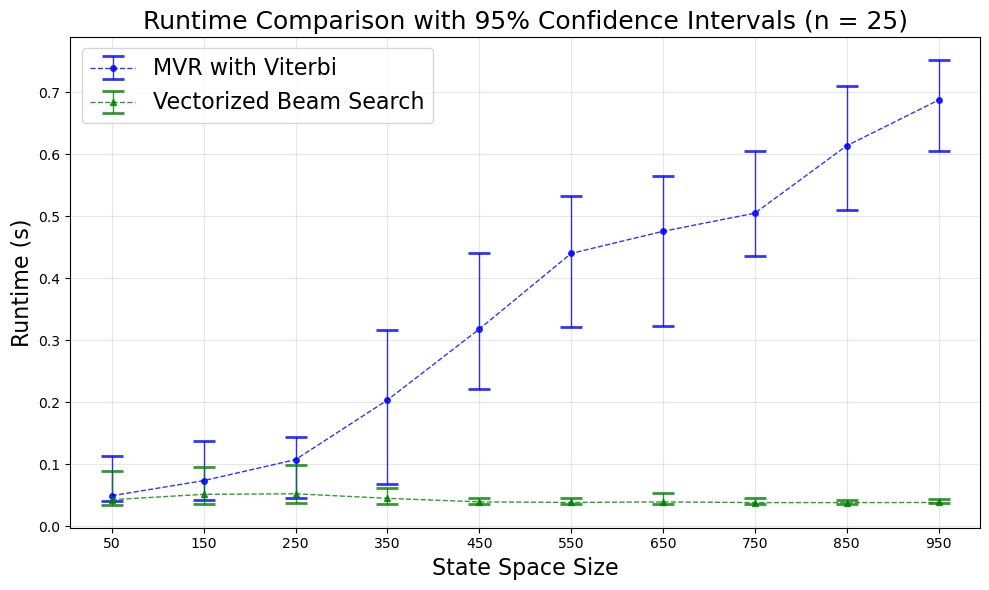

In [39]:
import matplotlib.pyplot as plt
import numpy as np


# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Algorithm 1 with error bars
ax.errorbar(sizes, means_1, yerr=[yerr_lower_1, yerr_upper_1],
            fmt='o--', color='blue', label='MVR with Viterbi',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

# Plot Algorithm 3 with error bars
ax.errorbar(sizes, means_3, yerr=[yerr_lower_3, yerr_upper_3],
            fmt='^--', color='green', label='Vectorized Beam Search',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

ax.set_xlabel('State Space Size', fontsize=16)
ax.set_ylabel('Runtime (s)', fontsize=16)
ax.set_xticks(sizes)
ax.set_title('Runtime Comparison with 95% Confidence Intervals (n = 25)', fontsize=18)
ax.legend(fontsize=16)
ax.grid(alpha=0.3)

plt.savefig('comparison_beamVec_time.png', format='png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

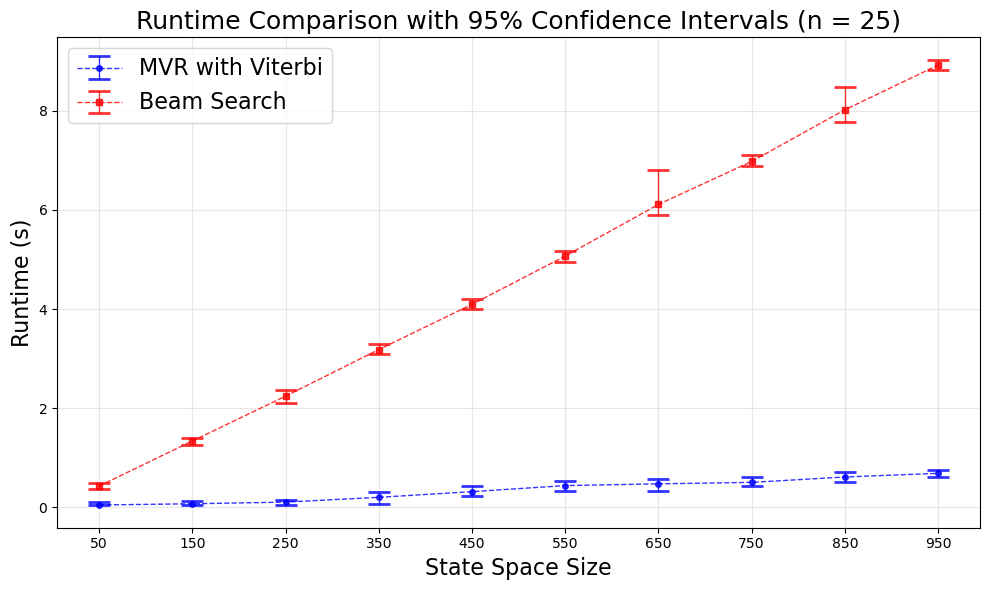

In [40]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Algorithm 1 with error bars
ax.errorbar(sizes, means_1, yerr=[yerr_lower_1, yerr_upper_1],
            fmt='o--', color='blue', label='MVR with Viterbi',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

# Plot Algorithm 2 with error bars
ax.errorbar(sizes, means_2, yerr=[yerr_lower_2, yerr_upper_2],
            fmt='s--', color='red', label='Beam Search',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

ax.set_xlabel('State Space Size', fontsize=16)
ax.set_ylabel('Runtime (s)', fontsize=16)
ax.set_xticks(sizes)
ax.set_title('Runtime Comparison with 95% Confidence Intervals (n = 25)', fontsize=18)
ax.legend(fontsize=16)
ax.grid(alpha=0.3)

plt.savefig('comparison_beam_time.png', format='png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Constraint Length vs Max Inferred Subsequence

In [11]:
constraint_lengths = [2*i for i in range(1,10)]
batch = 100
size = 50
device = torch.device("cuda:0")


#Generate HMM
num_states = size
num_emissions = 10
hmm_params = generate_random_hmm(num_states, num_emissions, seed=42)
transition_matrix, emission_matrix, initial_vector = hmm_params


hidden_states = list(range(num_states))
emit_states = list(range(num_emissions))
hidden_size, emit_size = len(hidden_states), len(emit_states)


hmm_transition = {}
for i in range(hidden_size):
    for j in range(hidden_size):
        hmm_transition[hidden_states[i],hidden_states[j]] = transition_matrix[i,j].item()

hmm_emit = {}
for i in range(hidden_size):
    for j in range(emit_size):
        hmm_emit[hidden_states[i],emit_states[j]] = emission_matrix[i,j].item()

hmm_startprob = {}
for i in range(hidden_size):
    hmm_startprob[hidden_states[i]] = initial_vector[i]

hmm = copy.deepcopy(Munch(states = hidden_states, emits = emit_states, tprob = hmm_transition, eprob = hmm_emit, initprob = hmm_startprob))


In [12]:
# Generate random HMM
accuracy_exp_beam = []
accuracy_exp_mv = []

for length in constraint_lengths:
    
    required_transitions = [(i, i+1) for i in range(length - 1)]

    states, observations = sample_from_hmm(
        transition_matrix, emission_matrix, initial_vector,
        sequence_length=100,
        constraint_length=length,  # Inject consecutive sequence when 0 is encountered
        seed=123
    )
    #Intialize bonus function for each size
    bonus_fn = create_sequence_bonus_incentive(
        constraint_length=length,
        bonus_per_transition=3.0
    )
    
    #Initialize bonus matrix 
    bonus_matrix, bonus_fn_vec = create_sequence_bonus_incentive_vectorized(
        constraint_length=length,
        bonus_per_transition=3.0,
        device=device,
        num_states=transition_matrix.shape[0]
    )
    # Attach the bonus matrix to the function for vectorized access
    bonus_fn_vec.bonus_matrix = bonus_matrix
    
    #Create constraint object for MVR
    seq_cst = create_seqconstraint(num_states,length)
    cst_list = [seq_cst]
    cst_parameters = create_seq_cst_params(num_states, length, device='cpu')

    #Initialize list of times
    accuracy_beam = []
    accuracy_mv = []
    #Runtime experiments
    for b in range(batch):
        if b % 10 == 0:
            print(f'On constraint length {length} and run {b}')
 
        states, observations = sample_from_hmm(
            transition_matrix, emission_matrix, initial_vector,
            sequence_length=100,
            constraint_length=length # Inject consecutive sequence when 0 is encountered
        )

        #Beam Search
        paths, scores = hmm_beam_search(
            transition_matrix=transition_matrix,
            emission_matrix=emission_matrix,
            initial_vector=initial_vector,
            observations=observations,
            beam_width=5,
            bonus_fn=bonus_fn
        )
        top_path = paths[0]
        max_consecutive_length = find_longest_consecutive_sequence(top_path, start_state=0, constraint_length = length)
        accuracy_beam.append(max_consecutive_length/length)
        
        #MV
        input_list = Viterbi_preprocess(hmm, cst_list, observations.tolist(), dtype = torch.float32,  device = 'cuda:0', debug = False, hmm_params = [transition_matrix,initial_vector], cst_params = cst_parameters)
        opt_state_list, opt_augstateix_list = Viterbi_torch_list(input_list, observations.tolist(), dtype = torch.float32,  device = 'cuda:0', debug = False, num_corr = 0)
        top_path = torch.tensor(opt_state_list)
        max_consecutive_length = find_longest_consecutive_sequence(top_path, start_state=0, constraint_length = length)
        accuracy_mv.append(max_consecutive_length/length)
    
    accuracy_exp_beam.append(accuracy_beam)
    accuracy_exp_mv.append(accuracy_mv)


On constraint length 2 and run 0
On constraint length 2 and run 10
On constraint length 2 and run 20
On constraint length 2 and run 30
On constraint length 2 and run 40
On constraint length 2 and run 50
On constraint length 2 and run 60
On constraint length 2 and run 70
On constraint length 2 and run 80
On constraint length 2 and run 90
On constraint length 4 and run 0
On constraint length 4 and run 10
On constraint length 4 and run 20
On constraint length 4 and run 30
On constraint length 4 and run 40
On constraint length 4 and run 50
On constraint length 4 and run 60
On constraint length 4 and run 70
On constraint length 4 and run 80
On constraint length 4 and run 90
On constraint length 6 and run 0
On constraint length 6 and run 10
On constraint length 6 and run 20
On constraint length 6 and run 30
On constraint length 6 and run 40
On constraint length 6 and run 50
On constraint length 6 and run 60
On constraint length 6 and run 70
On constraint length 6 and run 80
On constraint len

In [19]:
import pickle

with open('acc_exp_beam.pkl', 'wb') as f:
    pickle.dump([accuracy_exp_mv, accuracy_exp_beam], f)


# # Loading from pickle file
# with open('acc_exp_beam.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)


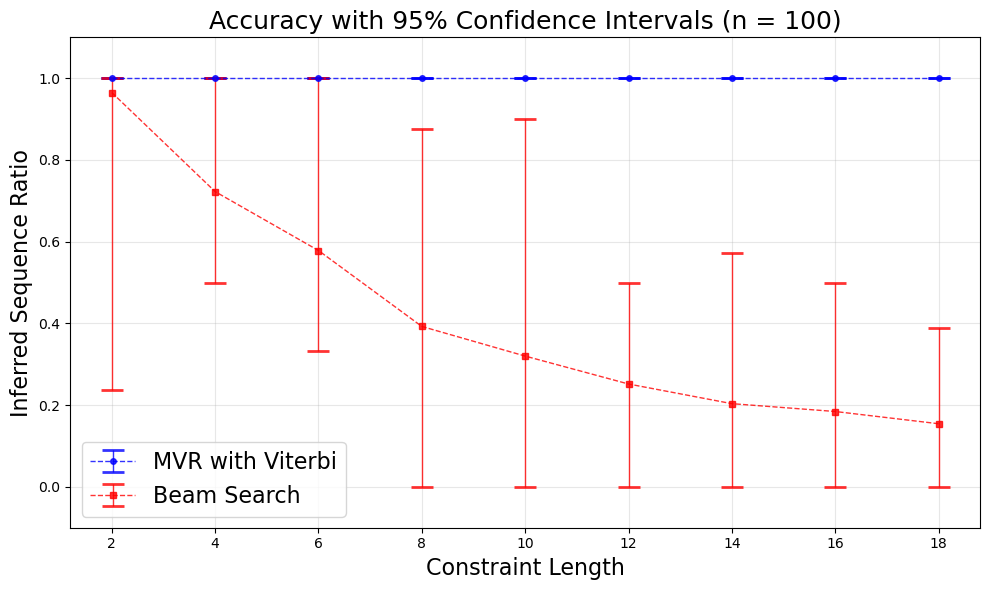

In [42]:
# Compute statistics for Algorithm 1
acc_means_1 = [np.mean(runs) for runs in accuracy_exp_mv]
acc_lower_1 = [np.percentile(runs, 2.5) for runs in accuracy_exp_mv]
acc_upper_1 = [np.percentile(runs, 97.5) for runs in accuracy_exp_mv]

# Compute statistics for Algorithm 2
acc_means_2 = [np.mean(runs) for runs in accuracy_exp_beam]
acc_lower_2 = [np.percentile(runs, 2.5) for runs in accuracy_exp_beam]
acc_upper_2 = [np.percentile(runs, 97.5) for runs in accuracy_exp_beam]


# Convert to error bar format (distance from mean)
acc_yerr_lower_1 = np.array(acc_means_1) - np.array(acc_lower_1)
acc_yerr_upper_1 = np.array(acc_upper_1) - np.array(acc_means_1)
acc_yerr_lower_2 = np.array(acc_means_2) - np.array(acc_lower_2)
acc_yerr_upper_2 = np.array(acc_upper_2) - np.array(acc_means_2)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Algorithm 1 with error bars
ax.errorbar(constraint_lengths, acc_means_1, yerr=[acc_yerr_lower_1.round(4), acc_yerr_upper_1.round(4)],
            fmt='o--', color='blue', label='MVR with Viterbi',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

# Plot Algorithm 2 with error bars
ax.errorbar(constraint_lengths, acc_means_2, yerr=[acc_yerr_lower_2.round(4), acc_yerr_upper_2.round(4)], #handle small negative values due to imprecision
            fmt='s--', color='red', label='Beam Search',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

ax.set_xlabel('Constraint Length', fontsize=16)
ax.set_ylabel('Inferred Sequence Ratio', fontsize=16)
ax.set_xticks(constraint_lengths)
ax.set_title('Accuracy with 95% Confidence Intervals (n = 100)', fontsize=18)
ax.legend(fontsize=16)
ax.set_ylim([-.1,1.1])
ax.grid(alpha=0.3)

plt.savefig('comparison_beam_accuracy.png', format='png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# ILP vs MV

## Runtime: Sequence Length

In [28]:
batch = 25
num_states = 10
num_emissions = 5
constraint_length = 2
seq_lengths = [3*i for i in range(1,6)]

device = torch.device("cuda:0")

required_transitions = [(i, i+1) for i in range(constraint_length - 1)]

#Generate HMM
hmm_params = generate_random_hmm(num_states, num_emissions, seed=42)
transition_matrix, emission_matrix, initial_vector = hmm_params


hidden_states = list(range(num_states))
emit_states = list(range(num_emissions))
hidden_size, emit_size = len(hidden_states), len(emit_states)


hmm_transition = {}
for i in range(hidden_size):
    for j in range(hidden_size):
        hmm_transition[hidden_states[i],hidden_states[j]] = transition_matrix[i,j].item()

hmm_emit = {}
for i in range(hidden_size):
    for j in range(emit_size):
        hmm_emit[hidden_states[i],emit_states[j]] = emission_matrix[i,j].item()

hmm_startprob = {}
for i in range(hidden_size):
    hmm_startprob[hidden_states[i]] = initial_vector[i]

hmm = copy.deepcopy(Munch(states = hidden_states, emits = emit_states, tprob = hmm_transition, eprob = hmm_emit, initprob = hmm_startprob))


#Create constraint object for MVR
seq_cst = create_seqconstraint(num_states,constraint_length)
cst_list = [seq_cst]
cst_parameters = create_seq_cst_params(num_states, constraint_length, device='cpu')


In [29]:
# Generate random HMM
length_exp_mv = []
length_exp_ilp = []

for length in seq_lengths:
    
    #Initialize list of times
    times_ilp = []
    times_mv = []
    #Runtime experiments
    for b in range(batch):
        if b % 10 == 0:
            print(f'On length {length} and run {b}')
 
        states, observations = sample_from_hmm(
            transition_matrix, emission_matrix, initial_vector,
            sequence_length=length,
            constraint_length=constraint_length  # Inject consecutive sequence when 0 is encountered
        )

        
        #MV
        input_list = Viterbi_preprocess(hmm, cst_list, observations.tolist(), dtype = torch.float32,  device = 'cuda:0', debug = False, hmm_params = [transition_matrix,initial_vector], cst_params = cst_parameters)
        start = time.time()
        opt_state_list, opt_augstateix_list = Viterbi_torch_list(input_list, observations.tolist(), dtype = torch.float32,  device = 'cuda:0', debug = False, num_corr = 0)
        time_elapsed = time.time() - start
        times_mv.append(time_elapsed)
        
        #ILP
        states, solve_time = hmm_constrained_inference(
            observations, transition_matrix, emission_matrix, initial_vector, constraint_length
        )
        times_ilp.append(solve_time)
        
    
    length_exp_ilp.append(times_ilp)
    length_exp_mv.append(times_mv)


On length 3 and run 0
On length 3 and run 10
On length 3 and run 20
On length 6 and run 0
On length 6 and run 10
On length 6 and run 20
On length 9 and run 0
On length 9 and run 10
On length 9 and run 20
On length 12 and run 0
On length 12 and run 10
On length 12 and run 20
On length 15 and run 0
On length 15 and run 10
On length 15 and run 20


In [33]:
import pickle

with open('length_exp_ilp.pkl', 'wb') as f:
    pickle.dump([length_exp_mv, length_exp_ilp], f)


# # Loading from pickle file
# with open('length_exp_ilp.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)


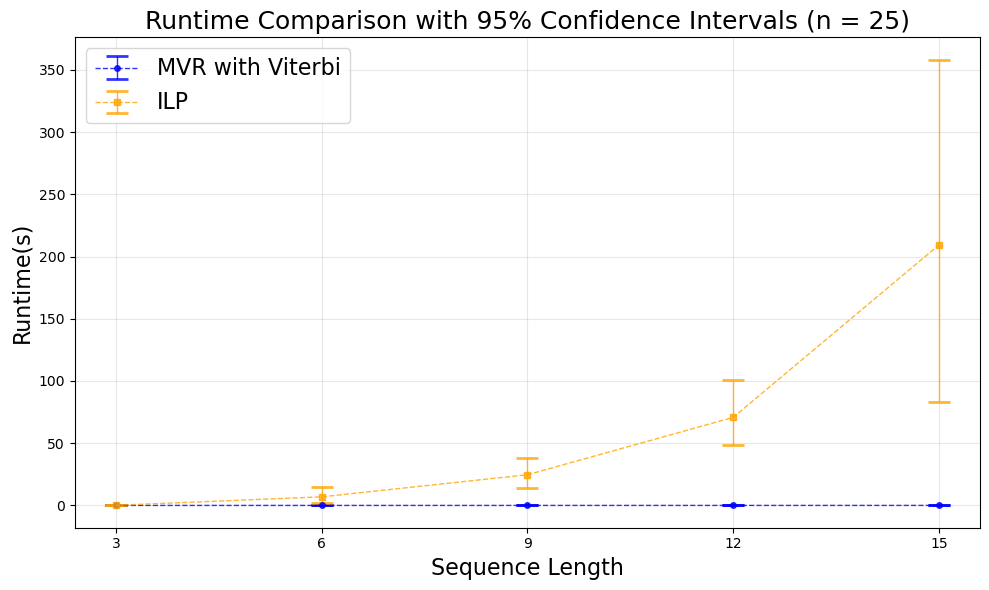

In [34]:
# Compute statistics for Algorithm 1
means_1 = [np.mean(runs) for runs in length_exp_mv]
lower_1 = [np.percentile(runs, 2.5) for runs in length_exp_mv]
upper_1 = [np.percentile(runs, 97.5) for runs in length_exp_mv]

# Compute statistics for Algorithm 2
means_2 = [np.mean(runs) for runs in length_exp_ilp]
lower_2 = [np.percentile(runs, 2.5) for runs in length_exp_ilp]
upper_2 = [np.percentile(runs, 97.5) for runs in length_exp_ilp]


# Convert to error bar format (distance from mean)
yerr_lower_1 = np.array(means_1) - np.array(lower_1)
yerr_upper_1 = np.array(upper_1) - np.array(means_1)
yerr_lower_2 = np.array(means_2) - np.array(lower_2)
yerr_upper_2 = np.array(upper_2) - np.array(means_2)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Algorithm 1 with error bars
ax.errorbar(seq_lengths, means_1, yerr=[yerr_lower_1.round(4), yerr_upper_1.round(4)],
            fmt='o--', color='blue', label='MVR with Viterbi',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

# Plot Algorithm 2 with error bars
ax.errorbar(seq_lengths, means_2, yerr=[yerr_lower_2.round(4), yerr_upper_2.round(4)], #handle small negative values due to imprecision
            fmt='s--', color='orange', label='ILP',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

ax.set_xlabel('Sequence Length', fontsize=16)
ax.set_ylabel('Runtime(s)', fontsize=16)
ax.set_xticks(seq_lengths)
ax.set_title('Runtime Comparison with 95% Confidence Intervals (n = 25)', fontsize=18)
ax.legend(fontsize=16)
# ax.set_ylim([-.1,1.1])
ax.grid(alpha=0.3)

plt.savefig('comparison_ilp_time.png', format='png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

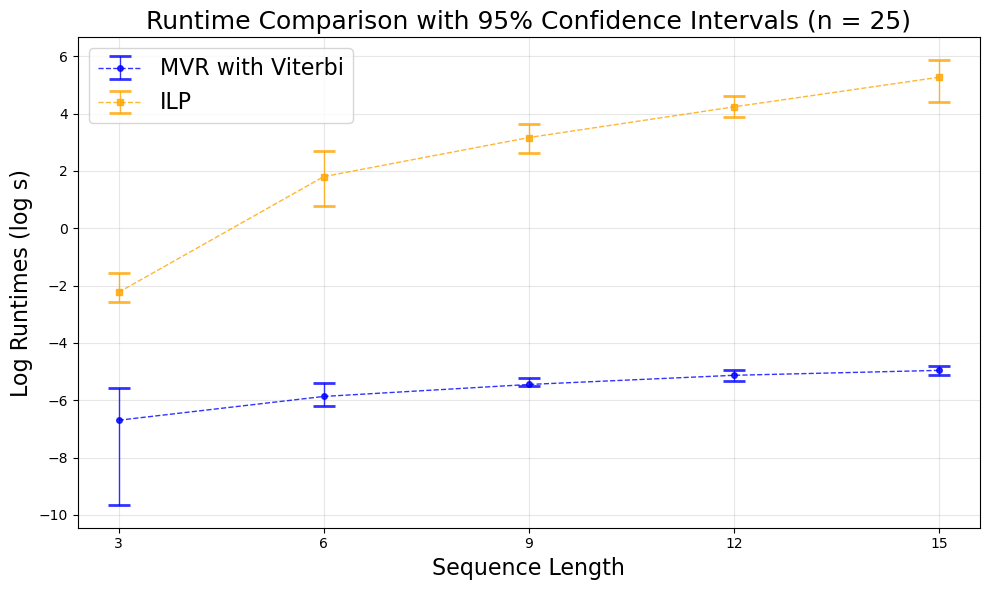

In [37]:
log_length_exp_mv = [[np.log(s + 1e-6) for s in runs] for runs in length_exp_mv]
log_length_exp_ilp = [[np.log(s + 1e-6) for s in runs] for runs in length_exp_ilp]

# Compute statistics for Algorithm 1
means_1 = [np.mean(runs) for runs in log_length_exp_mv]
lower_1 = [np.percentile(runs, 2.5) for runs in log_length_exp_mv]
upper_1 = [np.percentile(runs, 97.5) for runs in log_length_exp_mv]

# Compute statistics for Algorithm 2
means_2 = [np.mean(runs) for runs in log_length_exp_ilp]
lower_2 = [np.percentile(runs, 2.5) for runs in log_length_exp_ilp]
upper_2 = [np.percentile(runs, 97.5) for runs in log_length_exp_ilp]


# Convert to error bar format (distance from mean)
yerr_lower_1 = np.array(means_1) - np.array(lower_1)
yerr_upper_1 = np.array(upper_1) - np.array(means_1)
yerr_lower_2 = np.array(means_2) - np.array(lower_2)
yerr_upper_2 = np.array(upper_2) - np.array(means_2)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Algorithm 1 with error bars
ax.errorbar(seq_lengths, means_1, yerr=[yerr_lower_1.round(4), yerr_upper_1.round(4)],
            fmt='o--', color='blue', label='MVR with Viterbi',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

# Plot Algorithm 2 with error bars
ax.errorbar(seq_lengths, means_2, yerr=[yerr_lower_2.round(4), yerr_upper_2.round(4)], #handle small negative values due to imprecision
            fmt='s--', color='orange', label='ILP',
            capsize=8, capthick=2, linewidth=1, markersize=4, alpha=0.8)

ax.set_xlabel('Sequence Length', fontsize=16)
ax.set_ylabel('Log Runtimes (log s)', fontsize=16)
ax.set_xticks(seq_lengths)
ax.set_title('Runtime Comparison with 95% Confidence Intervals (n = 25)', fontsize=18)
ax.legend(fontsize=16)
# ax.set_ylim([-.1,1.1])
ax.grid(alpha=0.3)

plt.savefig('comparison_ilp_Logtime.png', format='png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [ ]:
batch = 25
state_size = []
num_emissions = 3
constraint_length = 2
seq_lengths = 10

device = torch.device("cuda:0")

required_transitions = [(i, i+1) for i in range(constraint_length - 1)]

#Generate HMM
hmm_params = generate_random_hmm(num_states, num_emissions, seed=42)
transition_matrix, emission_matrix, initial_vector = hmm_params


hidden_states = list(range(num_states))
emit_states = list(range(num_emissions))
hidden_size, emit_size = len(hidden_states), len(emit_states)


hmm_transition = {}
for i in range(hidden_size):
    for j in range(hidden_size):
        hmm_transition[hidden_states[i],hidden_states[j]] = transition_matrix[i,j].item()

hmm_emit = {}
for i in range(hidden_size):
    for j in range(emit_size):
        hmm_emit[hidden_states[i],emit_states[j]] = emission_matrix[i,j].item()

hmm_startprob = {}
for i in range(hidden_size):
    hmm_startprob[hidden_states[i]] = initial_vector[i]

hmm = copy.deepcopy(Munch(states = hidden_states, emits = emit_states, tprob = hmm_transition, eprob = hmm_emit, initprob = hmm_startprob))


#Create constraint object for MVR
seq_cst = create_seqconstraint(num_states,constraint_length)
cst_list = [seq_cst]
cst_parameters = create_seq_cst_params(num_states, constraint_length, device='cpu')


In [ ]:
# Generate random HMM
length_exp_mv = []
length_exp_ilp = []

for length in seq_lengths:
    
    #Initialize list of times
    times_ilp = []
    times_mv = []
    #Runtime experiments
    for b in range(batch):
        if b % 10 == 0:
            print(f'On length {length} and run {b}')
 
        states, observations = sample_from_hmm(
            transition_matrix, emission_matrix, initial_vector,
            sequence_length=length,
            constraint_length=constraint_length  # Inject consecutive sequence when 0 is encountered
        )

        
        #MV
        input_list = Viterbi_preprocess(hmm, cst_list, observations.tolist(), dtype = torch.float32,  device = 'cuda:0', debug = False, hmm_params = [transition_matrix,initial_vector], cst_params = cst_parameters)
        start = time.time()
        opt_state_list, opt_augstateix_list = Viterbi_torch_list(input_list, observations.tolist(), dtype = torch.float32,  device = 'cuda:0', debug = False, num_corr = 0)
        time_elapsed = time.time() - start
        times_mv.append(time_elapsed)
        
        #ILP
        states, solve_time = hmm_constrained_inference(
            observations, transition_matrix, emission_matrix, initial_vector, constraint_length
        )
        times_ilp.append(solve_time)
        
    
    length_exp_ilp.append(times_ilp)
    length_exp_mv.append(times_mv)


# Satisfaction Time Algorithm

In [985]:
def satTime_torch_list(hmm, cst_list, obs, pro_before = 30, dtype = torch.float32,  device = 'cpu', debug = False, hmm_params = None):
    '''
    more optimized torch implementation of Viterbi. The constraint all evolve independently (ie. factorial), so no need to create a big U_krjs matrix. Instead, just multiply along given dim. Still require computing V_{krjs}, but this should help.
    For numerica underflow, we normalize the value at each time. Also, we add a small constant num_corr when normalizing.

    For DNA, always assume that the promoter constraint is first.

    Assume that last constraint is the one whose sat time to compute.
    '''
    hmm = copy.deepcopy(hmm) #protect again in place modification
    #Generate emit_weights:
    emit_weights = compute_emitweights(obs, hmm)
    emit_weights = torch.from_numpy(emit_weights).type(dtype).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list, state_ix = convertTensor_list(hmm,cst_list, dtype = dtype, \
                                                               device = device, return_ix = True, hmm_params = hmm_params)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    #Assume that last constraint is the one whose sat time is estimated
    #Parameters for the other fixed constraints
    fixed_init, fixed_eval, fixed_upd = init_ind_list[:-2], final_ind_list[:-2], ind_list[:-2]

    #Parameters for estimated sat time constraint.
    sat_init, sat_true_eval, sat_upd = init_ind_list[-2:], final_ind_list[-2:], ind_list[-2:]
    sat_false_eval = [1-sat_true_eval[0], sat_true_eval[1]]
    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    alpha = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    gamma = torch.empty(alpha.shape, device = 'cpu')
    #beta doesn't need to track mediation space of estimate sat time. Dummy dim for last.
    beta = torch.empty((T, K) + tuple(dims_list[:-1]), device='cpu')
    sat_probs = torch.empty((T,))
    
    kr_indices = list(range(C+1))
    # fwd_kr_shape = (K,) + tuple(dims_list)
    js_indices = [k + C + 1 for k in kr_indices]


    #initialize. Let u,v denote the current/past indices of fixed constrained mediation space
    #indices are kurjvs
    gamma[0] = torch.einsum(emit_weights[0],[0], init_prob, [0],*fixed_init, *sat_init, *sat_false_eval, kr_indices).cpu()
    alpha[0] = torch.einsum(emit_weights[0],[0], init_prob, [0],*fixed_init, *sat_init, *sat_true_eval, kr_indices).cpu()
    beta[-1] = 1
    beta[-2] = torch.einsum(tmat,[C+1, 0], *fixed_upd, *fixed_eval[2:], emit_weights[-1], [0], js_indices[:-1]).cpu()

    #Compute forward messages:
    for t in range(1,T):
        #Common terms, summing over js indices.
        V = torch.einsum(gamma[t-1].to(device), js_indices, tmat, [C+1,0], emit_weights[t],[0], \
                                   *ind_list, kr_indices)

        if t == pro_before:
            gamma[t] = torch.einsum(V, kr_indices, *sat_false_eval, *fixed_upd[:2], kr_indices).cpu()
            alpha[t] = torch.einsum(V, kr_indices, *sat_true_eval, *fixed_upd[:2], kr_indices).cpu()
            
            # gamma[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                        *ind_list, *sat_false_eval, kr_indices, *final_ind_list[:2]).cpu()
            # alpha[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                *ind_list, *sat_true_eval, kr_indices, *final_ind_list[:2]).cpu()
        elif t == T -1 :
            gamma[t] = torch.einsum(V, kr_indices, *sat_false_eval, *fixed_upd[2:], kr_indices).cpu()
            alpha[t] = torch.einsum(V, kr_indices, *sat_true_eval, *fixed_upd[2:], kr_indices).cpu()
            
            # gamma[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                        *ind_list, *sat_false_eval, kr_indices, *final_ind_list[2:]).cpu()
            # alpha[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                *ind_list, *sat_true_eval, kr_indices, *final_ind_list[2:]).cpu()
        else:
            gamma[t] = torch.einsum(V, kr_indices, *sat_false_eval, kr_indices).cpu()
            alpha[t] = torch.einsum(V, kr_indices, *sat_true_eval, kr_indices).cpu()
            
            # gamma[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                        *ind_list, *sat_false_eval, kr_indices).cpu()
            # alpha[t] = torch.einsum(prev_gamma, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
            #                *ind_list, *sat_true_eval, kr_indices).cpu()



    #Compute backward messages
    for t in range(T-3,-1,-1):
        if t == pro_before:
            beta[t] = torch.einsum(beta[t+1].to(device), kr_indices[:-1], tmat, [C+1, 0], *fixed_upd, \
                               emit_weights[t+1], [0], *fixed_eval[:2], js_indices[:-1]).cpu()
        else:
            beta[t] = torch.einsum(beta[t+1].to(device), kr_indices[:-1], tmat, [C+1, 0], *fixed_upd, \
                               emit_weights[t+1], [0], js_indices[:-1]).cpu()

    #Compute moments
    for t in range(T):
        alpha_msg = alpha[t].to(device)
        beta_msg = beta[t].to(device)
        sat_probs[t] = torch.einsum('...i,... ->', alpha_msg, beta_msg)
        # sat_probs[t] = torch.einsum(alpha_msg, kr_indices, beta_msg, kr_indices[:-1])

    return sat_probs, alpha, beta

In [986]:
state_list, emit_list = simulation(hmm, time = 30, stay=3, pro_before=10, ix_list=None, max_attempts=1000)

In [987]:
sat_cst_list = [promoter_cst,stay_cst,pde_cst, hitdis_cst] #omit the disvisit constraint

In [988]:
sat_probs, alpha, beta = satTime_torch_list(hmm, sat_cst_list, emit_list, pro_before = 10, dtype = torch.float32,  device = 'cpu', debug = False)

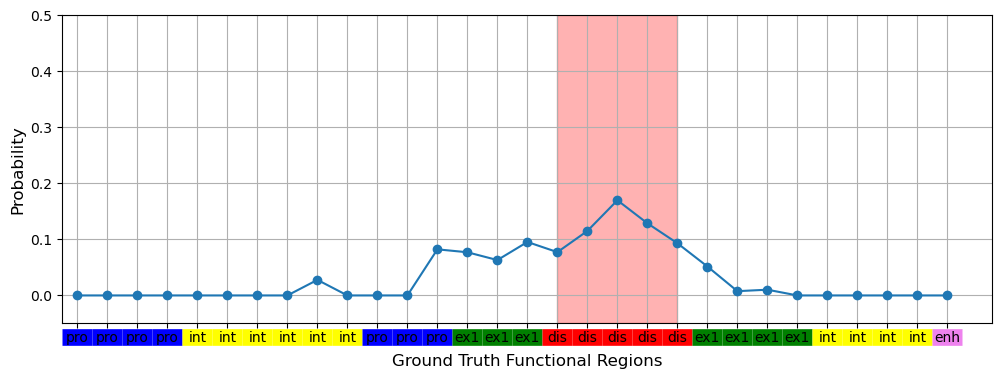

In [993]:
state_list, emit_list = simulation(hmm, time = 30, stay=3, pro_before=10, ix_list=None, max_attempts=1000)
sat_cst_list = [promoter_cst,stay_cst,pde_cst, hitdis_cst] #omit the disvisit constraint
sat_probs, alpha, beta = satTime_torch_list(hmm, sat_cst_list, emit_list, pro_before = 10, dtype = torch.float32,  device = 'cpu', debug = False)

common_list = ['pro', 'ex1', 'ex2', 'int', 'dis', 'enh']
colors = {
    'pro': 'blue',
    'ex1': 'green',
    'ex2': 'lime',
    'int': 'yellow',
    'dis': 'red',
    'enh': 'violet'
}

# Example data
plt.figure(figsize=(12, 4))
indices = list(range(len(state_list)))

norm_probs = sat_probs / sat_probs.sum()

plt.plot(indices, norm_probs.tolist(), marker='o')

# Create a segmented line with text inside the segments
tick_length = 1  # Length of each segment
y_position = -.075  # Position of the segmented line where x-labels would normally appear

x_start = -.5
for state in state_list:
    x_end = x_start + tick_length  # Each word occupies a segment of length tick_length
    
    # Draw the horizontal colored segment
    plt.plot([x_start, x_end], [y_position, y_position], color=colors[state], linewidth=12, solid_capstyle='butt', clip_on=False)  # Disable clipping
    
    # Add text inside the segment
    plt.text((x_start + x_end) / 2, y_position, state, fontsize=10, ha='center', va='center', clip_on=False)  # Disable clipping for text
    
    x_start = x_end

# Adding titles and labels
# plt.suptitle('Estimating the Mutation\'s Location', fontsize=14)  # LaTeX formula in title
# plt.title('Posterior Distribution of Constraint 3 Satisfaction Time', fontsize = 10)
plt.xlabel('Ground Truth Functional Regions', fontsize=12, labelpad = 15)  # LaTeX formula in xlabel
plt.ylabel('Probability', fontsize=12)  # LaTeX formula in ylabel

plt.xticks(indices, [''] * len(indices))  # Replace labels with empty strings

start = None
end = None
ix = 0
for state in state_list:
    if state == "dis":
        if start is None:  # First occurrence
            start = ix
        end = ix  # Update end to the current index
    ix += 1

plt.axvspan(start, end, color='red', alpha=0.3)  # Pale red color

# Show the grid
plt.grid()

# Adjust plot limits to make room for the segmented line
plt.ylim(-.05, .5)  # Add space below the x-axis for the segmented line
plt.xlim(-.5, 30.5)  # Add space below the x-axis for the segmented line

# plt.savefig('dna_satTime.png', format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Satisifaction Probability Estimation

In [27]:
def satprob_torch_list(hmm, cst_list, obs, pro_before = 30, dtype = torch.float32,  device = 'cpu', debug = False, num_corr = 0, hmm_params = None):
    '''
    more optimized torch implementation of Viterbi. The constraint all evolve independently (ie. factorial), so no need to create a big U_krjs matrix. Instead, just multiply along given dim. Still require computing V_{krjs}, but this should help.
    For numerica underflow, we normalize the value at each time. Also, we add a small constant num_corr when normalizing.

    For DNA, always assume that the promoter constraint is first.

    Assume that last constraint is the one whose sat time to compute.
    '''
    hmm = copy.deepcopy(hmm) #protect again in place modification
    #Generate emit_weights:
    emit_weights = compute_emitweights(obs, hmm)
    emit_weights = torch.from_numpy(emit_weights).type(dtype).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list, state_ix = convertTensor_list(hmm,cst_list, dtype = dtype, \
                                                               device = device, return_ix = True, hmm_params = hmm_params)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    #Assume that last constraint is the one whose sat time is estimated
    #Parameters for the other fixed constraints
    fixed_init, fixed_eval, fixed_upd = init_ind_list[:-2], final_ind_list[:-2], ind_list[:-2]

    #Parameters for estimated sat time constraint.
    sat_init, sat_true_eval, sat_upd = init_ind_list[-2:], final_ind_list[-2:], ind_list[-2:]
    sat_false_eval = [1-sat_true_eval[0], sat_true_eval[1]]
    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    
    kr_indices = list(range(C+1))
    # fwd_kr_shape = (K,) + tuple(dims_list)
    js_indices = [k + C + 1 for k in kr_indices]


    #initialize. Let u,v denote the current/past indices of fixed constrained mediation space
    #indices are kurjvs
    alpha = torch.einsum(emit_weights[0],[0], init_prob, [0],*fixed_init, *sat_init, kr_indices)
    alpha = alpha/(alpha.max() + num_corr) #normalize for stability
    #Compute forward messages:
    for t in range(1,T-1):
        #Common terms, summing over js indices.
        if t == pro_before:
            # alpha[t] = torch.einsum(V, kr_indices, *fixed_upd[:2], kr_indices).cpu()
            
            alpha = torch.einsum(alpha, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
                                       *ind_list, *final_ind_list[:2], kr_indices)
        else:
            alpha = torch.einsum(alpha, js_indices, tmat, [C+1,0], emit_weights[t],[0], \
                                       *ind_list, kr_indices)

        alpha = alpha/(alpha.max() + num_corr) #normalize for stability
    #compute final probs
    alpha_true = torch.einsum(alpha.to(device), js_indices, tmat, [C+1,0], emit_weights[t],[0], \
                               *ind_list, *fixed_eval, *sat_true_eval, kr_indices)
    alpha_false = torch.einsum(alpha.to(device), js_indices, tmat, [C+1,0], emit_weights[t],[0], \
                               *ind_list, *fixed_eval, *sat_false_eval, kr_indices)

    probs = torch.tensor([alpha_true.sum().cpu().item(), alpha_false.sum().cpu().item()] )
    probs = probs/probs.sum()
    
    return probs #, alpha_true, alpha_false

In [998]:
probs = satprob_torch_list(hmm, sat_cst_list, emit_list, pro_before = 10, dtype = torch.float32,  device = 'cpu', debug = False, num_corr = 0)

In [999]:
probs[0]

tensor(1.)

# Doesn't work for length 30

In [40]:
B = 100
probsat_cst_list = [promoter_cst,stay_cst, pe_cst, disvisit_atmost_cst, hitdis_cst]
prob_dis = []
for b in range(B):
    state_list, emit_list = simulation(hmm, time = 30, stay=3, pro_before=10, ix_list=None, max_attempts=1000)
    probs = satprob_torch_list(hmm, probsat_cst_list, emit_list, pro_before = 10, dtype = torch.float32,  device = 'cuda:0', debug = False, num_corr = 0)
    prob_dis.append(probs[0].item())

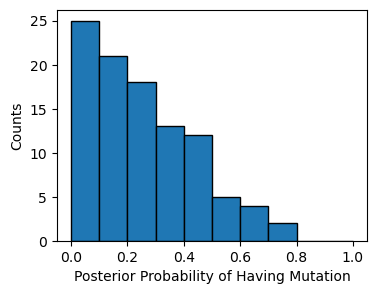

In [41]:
bins = np.linspace(0, 1, 11) 

plt.figure(figsize=(4, 3))

plt.hist(prob_dis, bins=bins, edgecolor='black')

# Adding titles and labels
# plt.title('Histogram of Probabilities')
plt.xlabel('Posterior Probability of Having Mutation')
plt.ylabel('Counts')

# Show the plot
plt.show()

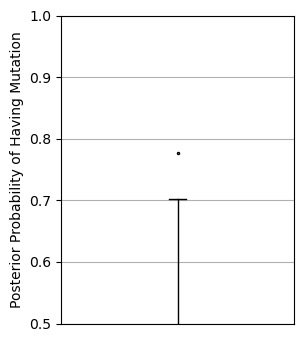

In [1004]:
plt.figure(figsize=(3, 4))
plt.boxplot(prob_dis, vert=True, patch_artist=True, flierprops=dict(marker='.', markersize=3))

# Adding titles and labels
# plt.title('Box Plot of Probabilities')
plt.ylabel('Posterior Probability of Having Mutation')
plt.ylim(.5,1)

plt.xticks([])

# plt.subplots_adjust(left=0.3, right=0.85)  # Adjust these values as needed

plt.grid()
plt.savefig('dna_postprob.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


In [1005]:
B = 100
long_prob_dis = []
for b in range(B):
    state_list, emit_list = simulation(hmm, time = 60, stay=6, pro_before=10, ix_list=None, max_attempts=1000)
    sat_cst_list = [promoter_cst,stay_cst, pe_cst, disvisit_atmost_cst, disvisit_cst]
    probs = satprob_torch_list(hmm, sat_cst_list, emit_list, pro_before = 10, dtype = torch.float32,  device = 'cuda:0', debug = False, num_corr = 0)
    long_prob_dis.append(probs[0].item())

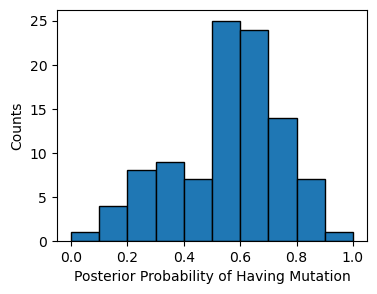

In [1006]:
bins = np.linspace(0, 1, 11) 

plt.figure(figsize=(4, 3))

plt.hist(long_prob_dis, bins=bins, edgecolor='black')

# Adding titles and labels
# plt.title('Histogram of Probabilities')
plt.xlabel('Posterior Probability of Having Mutation')
plt.ylabel('Counts')

# Show the plot
plt.show()

In [812]:
more_likely = 0
for p in long_prob_dis:
    if p > .5:
        more_likely += 1
more_likely/len(long_prob_dis)

0.66

In [507]:
state_list, emit_list = simulation(hmm, time = 30, stay=3, pro_before=10, ix_list=None, max_attempts=1000)

In [508]:
sat_cst_list = [promoter_cst,stay_cst, pe_cst, hitdis_cst]


In [509]:
probs = satprob_torch_list(hmm, sat_cst_list, emit_list, pro_before = 10, dtype = torch.float32,  device = 'cpu', debug = False, num_corr = 0)

In [510]:
probs

tensor([0.7177, 0.2823])